# Conditional GAN - MNIST

In [1]:
import os
import numpy as np
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

In [2]:
torch.__version__

'1.11.0'

In [3]:
os.makedirs("samples", exist_ok=True)

## Hyper Parameters

In [4]:
epoch =0            # "epoch to start training from"
n_epochs = 100      # "number of epochs of training"
batch_size = 64     # "size of the batches"
lr = 0.0002         # "learning rate"
b1 = 0.5            # "Adam: decay of first order momentum of gradient"
b2 = 0.999          # "Adam: decay of first order momentum of gradient"
n_cpu = 8           # "number of cpu threads to use during batch generation"
img_height = 28     # "size of image height"
img_width = 28      # "size of image width"
channels = 1        # "number of image channels"
z_dim = 100         # "dim of latent z"
n_classes = 10      # "number of classes"
sample_interval = 1 # "interval between sampling of images from generators"

## Train Setting

In [5]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# imgage size
img_shape = (channels, img_width, img_height)
img_dim = img_width * img_height 

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root='../mnist_data/', train=True, transform=transform, download=True)
# test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    num_workers=n_cpu,
    shuffle=True
)

## Generator

In [6]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, n_classes):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.output_dim = output_dim
        
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(input_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), self.output_dim)
        return img

## Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, n_classes):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(input_dim)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [8]:
# build network
generator = Generator(input_dim=z_dim, output_dim=img_dim, n_classes=n_classes).to(device)
discriminator = Discriminator(img_dim, n_classes=n_classes).to(device)
    
# loss
adversarial_loss = nn.BCEWithLogitsLoss().to(device)
# criterion = nn.BCELoss().to(device)
    
# optimizer
G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))


## Generator Loss

#### generator loss
1. Generate Random noise z

2. Generator makes fake image using noise z

3. Discriminator evaluate whether this image is fake or real

4. Calculate generator loss

In [9]:
def generator_loss(generator):
    z = torch.normal(mean=torch.zeros((batch_size, z_dim)), std=torch.ones((batch_size, z_dim))).to(device)
    gen_labels = torch.randint(0, n_classes, (batch_size,)).to(device)
    valid = torch.ones(batch_size, 1).to(device)
    
    # Generator loss
    fake_G = generator(z, gen_labels)
    pred_fake = discriminator(fake_G, gen_labels)
    G_loss = adversarial_loss(pred_fake, valid)
    
    return G_loss

## Discriminator Loss

#### real Loss
1. Discriminator evaluate whether real image is fake or real

2. Calculate fake loss


#### fake Loss
1. Generator makes fake image using Random noise z

2. Discriminator evaluate whether this fake image is fake or real

3. Calculate fake loss

In [10]:
def discriminator_loss(discriminator, real_imgs, labels):
    valid = torch.ones(real_imgs.size(0), 1).to(device)
    fake = torch.zeros(real_imgs.size(0), 1).to(device)
    
    # real Loss
    pred_real = discriminator(real_imgs, labels)
    real_loss = adversarial_loss(pred_real, valid)

    # fake Loss
    z = torch.normal(mean=torch.zeros((real_imgs.size(0), z_dim)), std=torch.ones((real_imgs.size(0), z_dim))).to(device)
    gen_labels = torch.randint(0, n_classes, (real_imgs.size(0),)).to(device)
    
    fake_G = generator(z, gen_labels)
            
    pred_fake = discriminator(fake_G, gen_labels)
    fake_loss = adversarial_loss(pred_fake, fake)
    
    return  0.5 * (real_loss + fake_loss)

## Train

#### Training Process
1. Train Generator
2. Train Discriminator

In [11]:
for epoch in range(epoch, n_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
            
        # Configure input
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # ------------------
        #  Train Generators
        # ------------------
        G_optimizer.zero_grad()
        
        G_loss = generator_loss(generator) 
        G_loss.backward()
        G_optimizer.step()
    
        # ---------------------
        #  Train Discriminator
        # ---------------------
        D_optimizer.zero_grad()

        D_loss = discriminator_loss(discriminator, real_imgs, labels)
        D_loss.backward()
        D_optimizer.step()
        
        if i % 100 == 0:
            sys.stdout.write(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]\n"
                % (epoch, n_epochs, i, len(train_loader), D_loss.item(), G_loss.item())
            )
            
            
    # If at sample interval save image
    if epoch % sample_interval == 0:
        with torch.no_grad():
            test_z = torch.randn(100, z_dim).to(device)
            test_labels = torch.arange(n_classes).repeat_interleave(n_classes).to(device)
            
            generated = generator(test_z, test_labels)
            save_image(generated.view(generated.size(0), 1, 28, 28), './samples/sample_' + str(epoch) + '.png', nrow=10)

[Epoch 0/100] [Batch 0/938] [D loss: 0.675402] [G loss: 0.682249]
[Epoch 0/100] [Batch 100/938] [D loss: 0.480887] [G loss: 1.558548]
[Epoch 0/100] [Batch 200/938] [D loss: 0.458802] [G loss: 1.263674]
[Epoch 0/100] [Batch 300/938] [D loss: 0.435107] [G loss: 1.557426]
[Epoch 0/100] [Batch 400/938] [D loss: 0.751226] [G loss: 0.403722]
[Epoch 0/100] [Batch 500/938] [D loss: 1.024132] [G loss: 4.193316]
[Epoch 0/100] [Batch 600/938] [D loss: 0.456666] [G loss: 1.345450]
[Epoch 0/100] [Batch 700/938] [D loss: 0.271079] [G loss: 2.238102]
[Epoch 0/100] [Batch 800/938] [D loss: 0.385291] [G loss: 2.346975]
[Epoch 0/100] [Batch 900/938] [D loss: 0.330734] [G loss: 1.842307]
[Epoch 1/100] [Batch 0/938] [D loss: 0.296868] [G loss: 2.270540]
[Epoch 1/100] [Batch 100/938] [D loss: 0.894483] [G loss: 0.484347]
[Epoch 1/100] [Batch 200/938] [D loss: 0.286777] [G loss: 1.792779]
[Epoch 1/100] [Batch 300/938] [D loss: 0.262854] [G loss: 2.218455]
[Epoch 1/100] [Batch 400/938] [D loss: 0.290432] [G 

KeyboardInterrupt: 

### Evaluate Generator's fake Image

In [22]:
with torch.no_grad():
    test_z = torch.randn(100, z_dim).to(device)
    test_labels = torch.arange(n_classes).repeat_interleave(n_classes).to(device)
    generated = generator(test_z, test_labels)
    
    
    save_image(generated.view(generated.size(0), 1, 28, 28), './samples/sample.png', nrow=10)

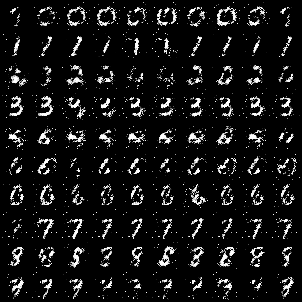

In [23]:
from PIL import Image

Image.open('./samples/sample.png')